In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import geobr

%matplotlib inline

In [2]:
#Dados
df = pd.read_excel('/home/marchesotti/Downloads/tabela1378_2.xlsx', skiprows=5, index_col='Unnamed: 0')
shape_muni = geobr.read_municipality(code_muni='all', year=2010, simplified=True, verbose=False)
estados = geobr.read_state(code_state='all', year=2018)

In [3]:
df

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Total,Homens,Mulheres
1100015,Alta Floresta D'Oeste (RO),Total,Total,24392.0,12656.0,11736.0
NaN,NaN,60 a 69 anos,Total,1227.0,652.0,575.0
NaN,NaN,70 anos ou mais,Total,860.0,491.0,369.0
1100023,Ariquemes (RO),Total,Total,90353.0,45543.0,44810.0
NaN,NaN,60 a 69 anos,Total,3674.0,1898.0,1776.0
...,...,...,...,...,...,...
NaN,NaN,70 anos ou mais,Total,209.0,112.0,97.0
5300108,Brasília (DF),Total,Total,2570160.0,1228880.0,1341280.0
NaN,NaN,60 a 69 anos,Total,118042.0,52049.0,65993.0
NaN,NaN,70 anos ou mais,Total,79571.0,32933.0,46638.0


In [4]:
#Verificando se há diferenças nos dados da Tabela do Sidra e dos dados oferecidos pelo geobr
teste1 = [float(x) for x in df.dropna().index.values]
teste2 = shape_muni['code_muni'].values
diferencas = []

for item in teste2:
    if item not in teste1:
        diferencas.append(item)
diferencas

[4300001.0, 4300002.0]

In [5]:
shape_muni[shape_muni['name_muni'] == 'Lagoa Dos Patos']

,code_muni,name_muni,code_state,abbrev_state,geometry
2669,3137304.0,Lagoa Dos Patos,31,MG,"MULTIPOLYGON (((-44.51250 -16.94176, -44.50472..."
4604,4300002.0,Lagoa Dos Patos,43,RS,"MULTIPOLYGON (((-52.08379 -32.18861, -52.08731..."


In [6]:
shape_muni[shape_muni['name_muni'] == 'Lagoa Mirim']

,code_muni,name_muni,code_state,abbrev_state,geometry
4603,4300001.0,Lagoa Mirim,43,RS,"MULTIPOLYGON (((-52.62242 -32.14398, -52.62241..."


In [7]:
#Havia uma diferença de duas linhas entre a Tabela e os dados do geobr. O problema foi que na base do geobr temos duas
#"Lagoa dos patos" e uma delas (a do Rio Grande do Sul) não aparece na Tabela do Sidra de 2010. Além disso, o outro suposto
#município, Lagoa Mirim, também não aparece. Então para não haver erro de atribuição de código no merge vou descartar
#os dois.

#Eu dei uma pesquisada acerca desses supostos municípios. O geobr considerou os dois como municípios mais ao que parece
#são literalmente lagos do extremo sul do Rio Grande do Sul, fazendo fronteira com o Uruguai. 
excluidos = [x for x in shape_muni.index if (x == 4603 or x == 4604)]
shape_muni = shape_muni.drop(excluidos)
shape_muni = shape_muni.reset_index(drop=True)
shape_muni

,code_muni,name_muni,code_state,abbrev_state,geometry
0,1100015.0,Alta Floresta D'oeste,11,RO,"MULTIPOLYGON (((-62.24620 -11.90149, -62.24151..."
1,1100023.0,Ariquemes,11,RO,"MULTIPOLYGON (((-63.13712 -9.78413, -63.09013 ..."
2,1100031.0,Cabixi,11,RO,"MULTIPOLYGON (((-60.52408 -13.32137, -60.37161..."
3,1100049.0,Cacoal,11,RO,"MULTIPOLYGON (((-61.42679 -11.11376, -61.42900..."
4,1100056.0,Cerejeiras,11,RO,"MULTIPOLYGON (((-61.41347 -13.23417, -61.42603..."
...,...,...,...,...,...
5560,5222005.0,Vianópolis,52,GO,"POLYGON ((-48.54164 -16.74126, -48.53274 -16.7..."
5561,5222054.0,Vicentinópolis,52,GO,"POLYGON ((-49.90713 -17.61460, -49.90588 -17.6..."
5562,5222203.0,Vila Boa,52,GO,"POLYGON ((-46.97635 -14.93112, -46.94801 -15.0..."
5563,5222302.0,Vila Propício,52,GO,"POLYGON ((-48.86700 -15.09735, -48.86191 -15.0..."


In [8]:
#Verificando novamente
teste1 = [float(x) for x in df.dropna().index.values]
teste2 = shape_muni['code_muni'].values
diferencas = []
for item in teste2:
    if item not in teste1:
        diferencas.append(item)
diferencas

[]

In [9]:
indices = [float(x) for x in df.dropna().index.values]
municipios = [df['Unnamed: 1'][i] for i in range(0, len(df)-1, 3)]
total = [df['Total'][i] for i in range(0, len(df)-1, 3)]
homens = [df.iloc[i+1]['Homens'] + df.iloc[i+2]['Homens'] for i in range(0, len(df)-2, 3)]
mulheres = [df.iloc[i+1]['Mulheres'] + df.iloc[i+2]['Mulheres'] for i in range(0, len(df)-2, 3)]
total_idosos = [df.iloc[i+1]['Total'] + df.iloc[i+2]['Total'] for i in range(0, len(df)-2, 3)]

In [10]:
print(len(indices), len(municipios), len(total), len(homens), len(mulheres), len(total_idosos))

5565 5565 5565 5565 5565 5565


In [11]:
def teste(arr1, arr2):
    for i in range(len(municipios)):
        if(arr1[i] != arr2[i]): return("Inconsistência")
    return "Passou"

#Testando array de municipios
print(teste(municipios, df.dropna()['Unnamed: 1'].values))


Passou


In [12]:
data = []
for i in range(len(indices)):
    data.append([indices[i], municipios[i], homens[i], mulheres[i], total_idosos[i], total[i]])
data

[[1100015.0, "Alta Floresta D'Oeste (RO)", 1143.0, 944.0, 2087.0, 24392.0],
 [1100023.0, 'Ariquemes (RO)', 3210.0, 2884.0, 6094.0, 90353.0],
 [1100031.0, 'Cabixi (RO)', 359.0, 287.0, 646.0, 6313.0],
 [1100049.0, 'Cacoal (RO)', 3255.0, 3221.0, 6476.0, 78574.0],
 [1100056.0, 'Cerejeiras (RO)', 869.0, 812.0, 1681.0, 17029.0],
 [1100064.0, 'Colorado do Oeste (RO)', 1067.0, 973.0, 2040.0, 18591.0],
 [1100072.0, 'Corumbiara (RO)', 402.0, 327.0, 729.0, 8783.0],
 [1100080.0, 'Costa Marques (RO)', 495.0, 348.0, 843.0, 13678.0],
 [1100098.0, "Espigão D'Oeste (RO)", 1187.0, 1108.0, 2295.0, 28729.0],
 [1100106.0, 'Guajará-Mirim (RO)', 1547.0, 1535.0, 3082.0, 41656.0],
 [1100114.0, 'Jaru (RO)', 2171.0, 2081.0, 4252.0, 52005.0],
 [1100122.0, 'Ji-Paraná (RO)', 4356.0, 4510.0, 8866.0, 116610.0],
 [1100130.0, "Machadinho D'Oeste (RO)", 1273.0, 829.0, 2102.0, 31135.0],
 [1100148.0, "Nova Brasilândia D'Oeste (RO)", 968.0, 737.0, 1705.0, 19874.0],
 [1100155.0, 'Ouro Preto do Oeste (RO)', 1658.0, 1709.0, 3

In [13]:
new_df = pd.DataFrame(data, columns=['Código', 'Municípios', 'S_Homens', 'S_Mulheres', 'Total_Idosos', 'Total'])
new_df

,Código,Municípios,S_Homens,S_Mulheres,Total_Idosos,Total
0,1100015.0,Alta Floresta D'Oeste (RO),1143.0,944.0,2087.0,24392.0
1,1100023.0,Ariquemes (RO),3210.0,2884.0,6094.0,90353.0
2,1100031.0,Cabixi (RO),359.0,287.0,646.0,6313.0
3,1100049.0,Cacoal (RO),3255.0,3221.0,6476.0,78574.0
4,1100056.0,Cerejeiras (RO),869.0,812.0,1681.0,17029.0
...,...,...,...,...,...,...
5560,5222005.0,Vianópolis (GO),638.0,690.0,1328.0,12548.0
5561,5222054.0,Vicentinópolis (GO),321.0,266.0,587.0,7371.0
5562,5222203.0,Vila Boa (GO),171.0,121.0,292.0,4735.0
5563,5222302.0,Vila Propício (GO),325.0,251.0,576.0,5145.0


In [14]:
join_df = pd.merge(new_df, shape_muni, left_on='Código', right_on='code_muni', how='left')
columns = ['Código', 'Municípios', 'S_Homens', 'S_Mulheres', 'Total_Idosos', 'Total', 'geometry']
join_df = join_df[columns]
join_df.head()

,Código,Municípios,S_Homens,S_Mulheres,Total_Idosos,Total,geometry
0,1100015.0,Alta Floresta D'Oeste (RO),1143.0,944.0,2087.0,24392.0,"MULTIPOLYGON (((-62.24620 -11.90149, -62.24151..."
1,1100023.0,Ariquemes (RO),3210.0,2884.0,6094.0,90353.0,"MULTIPOLYGON (((-63.13712 -9.78413, -63.09013 ..."
2,1100031.0,Cabixi (RO),359.0,287.0,646.0,6313.0,"MULTIPOLYGON (((-60.52408 -13.32137, -60.37161..."
3,1100049.0,Cacoal (RO),3255.0,3221.0,6476.0,78574.0,"MULTIPOLYGON (((-61.42679 -11.11376, -61.42900..."
4,1100056.0,Cerejeiras (RO),869.0,812.0,1681.0,17029.0,"MULTIPOLYGON (((-61.41347 -13.23417, -61.42603..."


In [15]:
copy = join_df

In [16]:
razao = join_df.groupby(['Municípios'], sort=False).apply(lambda x: 100*(x['Total_Idosos']/x['Total']))


In [17]:
copy['idosos/total'] = razao.values
copy

,Código,Municípios,S_Homens,S_Mulheres,Total_Idosos,Total,geometry,idosos/total
0,1100015.0,Alta Floresta D'Oeste (RO),1143.0,944.0,2087.0,24392.0,"MULTIPOLYGON (((-62.24620 -11.90149, -62.24151...",8.556084
1,1100023.0,Ariquemes (RO),3210.0,2884.0,6094.0,90353.0,"MULTIPOLYGON (((-63.13712 -9.78413, -63.09013 ...",6.744657
2,1100031.0,Cabixi (RO),359.0,287.0,646.0,6313.0,"MULTIPOLYGON (((-60.52408 -13.32137, -60.37161...",10.232853
3,1100049.0,Cacoal (RO),3255.0,3221.0,6476.0,78574.0,"MULTIPOLYGON (((-61.42679 -11.11376, -61.42900...",8.241912
4,1100056.0,Cerejeiras (RO),869.0,812.0,1681.0,17029.0,"MULTIPOLYGON (((-61.41347 -13.23417, -61.42603...",9.871396
...,...,...,...,...,...,...,...,...
5560,5222005.0,Vianópolis (GO),638.0,690.0,1328.0,12548.0,"POLYGON ((-48.54164 -16.74126, -48.53274 -16.7...",10.583360
5561,5222054.0,Vicentinópolis (GO),321.0,266.0,587.0,7371.0,"POLYGON ((-49.90713 -17.61460, -49.90588 -17.6...",7.963641
5562,5222203.0,Vila Boa (GO),171.0,121.0,292.0,4735.0,"POLYGON ((-46.97635 -14.93112, -46.94801 -15.0...",6.166843
5563,5222302.0,Vila Propício (GO),325.0,251.0,576.0,5145.0,"POLYGON ((-48.86700 -15.09735, -48.86191 -15.0...",11.195335


In [18]:
#Fazendo o typecasting para GeoDataFrame
join_df = gpd.GeoDataFrame(join_df)
copy = gpd.GeoDataFrame(copy)

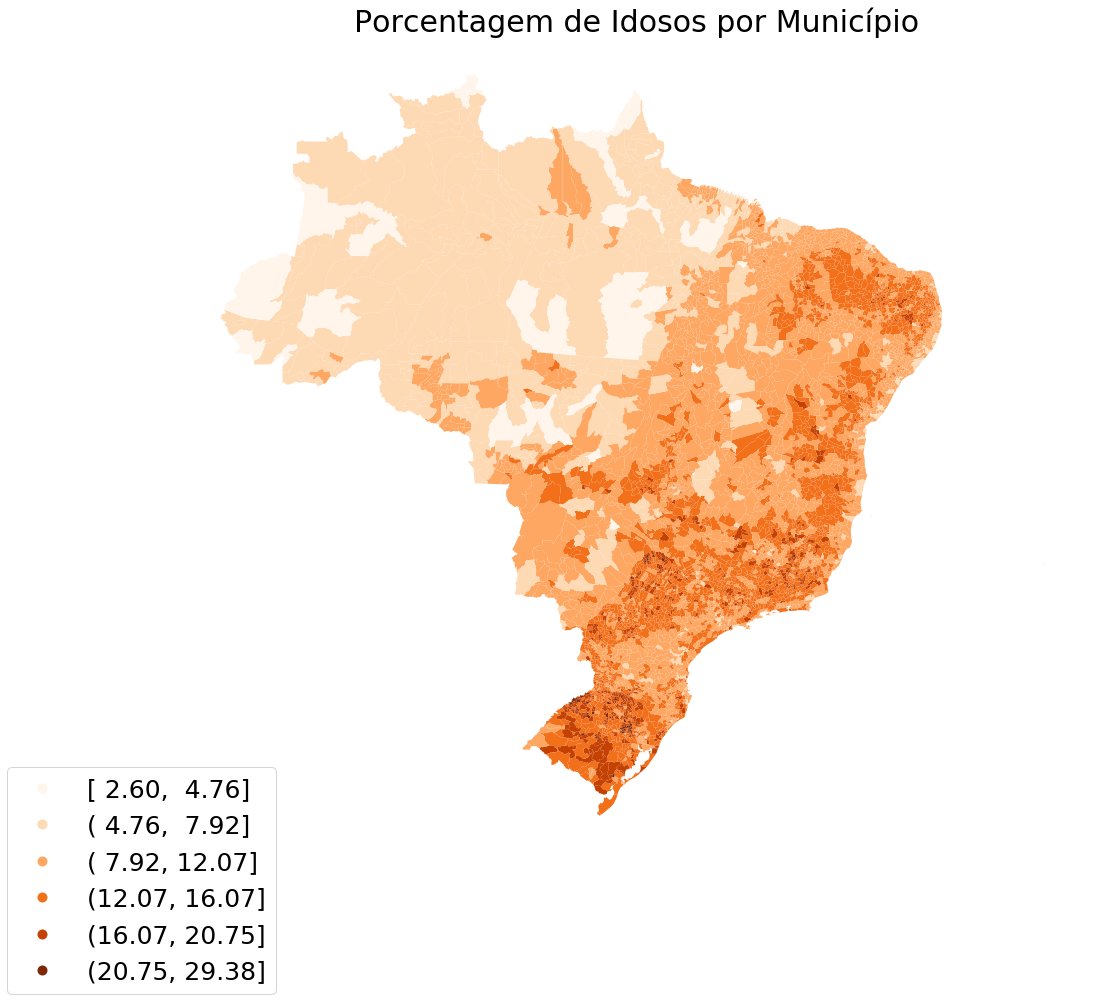

In [29]:
plt.rcParams['legend.fontsize'] = 25
#Plot antigo

fig, ax = plt.subplots(figsize=(20, 15))
copy.plot(column='idosos/total', cmap='Oranges', scheme='percentiles', k=5, legend=True, ax=ax)

ax.set_title("Porcentagem de Idosos por Município", fontdict={'fontsize':30})
ax.axis('off')
ax.get_legend().set_bbox_to_anchor((.12,.12))

In [20]:
#Teste é o shape dos estados que é retornado pelo read_state do geobr.
copy2 = estados

In [21]:
copy2['coords'] = copy2['geometry'].apply(lambda x: x.representative_point().coords[:])
copy2['coords'] = [coords[0] for coords in copy2['coords']]

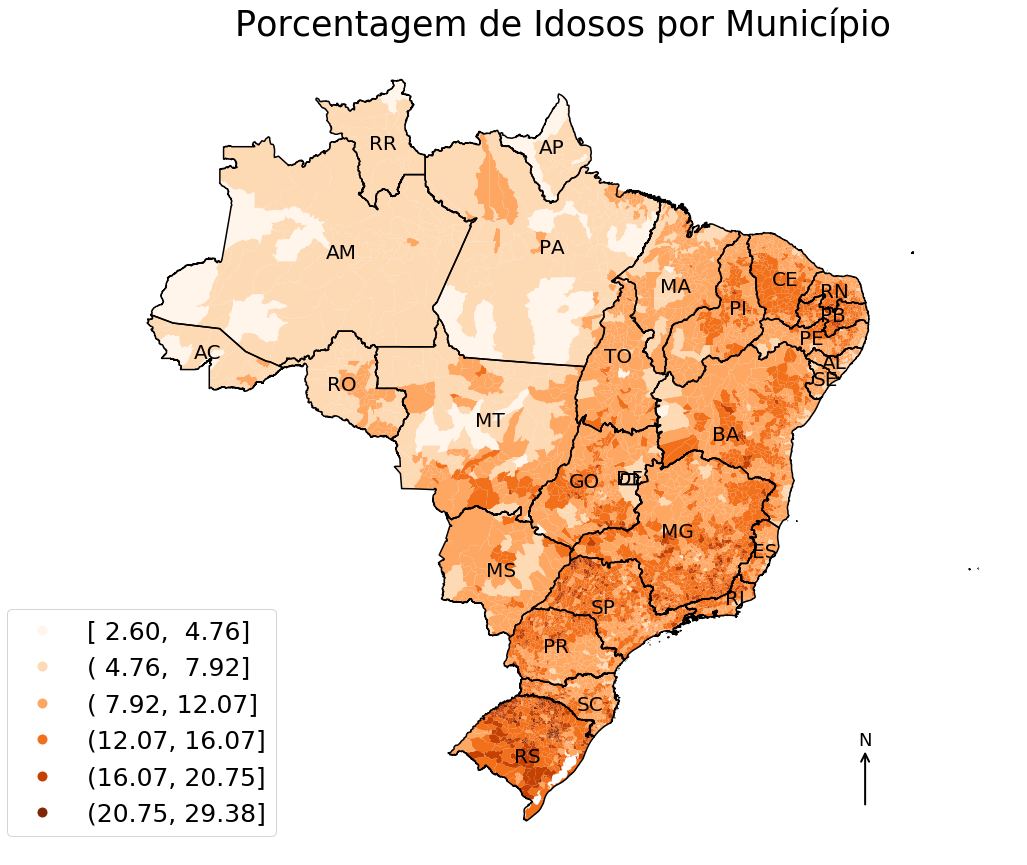

In [41]:
fig, ax = plt.subplots(figsize=(20, 15))
copy.plot(column='idosos/total', cmap='Oranges', scheme='percentiles', k=5, legend=True, ax=ax)
ax.set_title("Porcentagem de Idosos por Município", fontdict={'fontsize':35})
ax.axis('off')
ax.get_legend().set_bbox_to_anchor((.2,.32))
ax.annotate('', xy=(-35, -30), xytext=(-35, -33), arrowprops=dict(arrowstyle= '->', color='k', lw=2, mutation_scale=20))
ax.text(-35, -30, "N", ha="center", va="bottom", size=18)
#Atualizações
copy2.boundary.plot(figsize=(15, 15), color='black', ax=ax)

for i, j in copy2.iterrows():
    plt.annotate(s=j[1], xy=j['coords'], horizontalalignment='center', verticalalignment='center', fontsize=20)



In [42]:
fig.savefig('/home/marchesotti/Downloads/idosos_por_municipio.png')